# Tully-Fisher Secondary Target Sample

In [54]:
import os
import csv
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table, QTable, Column, setdiff
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy import constants
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

import sqlite3
from contextlib import closing

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

## SQLite3 Query

See if we have a cached copy of the query results (in FITS format) before running this query.

Use this query or the csv file to obtain the data.

In [3]:
# # Change use_cached = False if we want to redo the query at some point.
# use_cached = True

# if os.path.exists('tf_targets.fits') and use_cached:
#     tf_targets = Table.read('tf_targets.fits')
# else:
#     query = "select distinct pv.BRICKID, pv.OBJID, ifnull(pv.SGA_ID, 0), pv.POINTINGID, fd.TARGETID, fd.TARGET_RA, fd.TARGET_DEC, pv.PVTYPE, zd.Z, zd.ZERR, zd.SPECTYPE, zd.DELTACHI2, zd.ZWARN \
#             from (select distinct BRICKID, OBJID, PVTYPE, SGA_ID, POINTINGID from proposals_pv \
#             where (PVTYPE like 'TFT' or PVTYPE like 'EXT' or PVTYPE like 'SGA')) pv \
#             inner join fibermap_daily fd \
#             on (pv.BRICKID = fd.BRICKID) and (pv.OBJID = fd.BRICK_OBJID) \
#             inner join zbest_daily zd \
#             on zd.TARGETID=fd.TARGETID \
#             group by pv.BRICKID, pv.OBJID, fd.TARGETID;"

#     with closing(sqlite3.connect('/global/cfs/cdirs/desi/science/td/db/desi.db')) as db:
#         with closing(db.cursor()) as cursor:
#             rows = cursor.execute(query).fetchall()

#     tf_targets = Table(list(map(list, zip(*rows))),
#                         names=['BRICKID', 'FIBER_RA','FIBER_DEC', 'OBJID', 'SGA_ID', 'POINTINGID', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'PVTYPE', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
    
#     # Cache output for later.
#     tf_targets.write('tf_targets.fits', overwrite=True)

In [56]:
#Imports the DESI data that will be analyzed in this project
tf_targets = Table.read('/global/project/projectdirs/desi/science/td/pv/pv_tf_targets.csv', format='ascii.csv')
tf_targets.write('tf_targets.fits', overwrite=True)
len(tf_targets)

25497

In [57]:
tf_targets[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,GALAXY,33952.1068879628,0,69412,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,GALAXY,53137.0094233155,0,69412,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,GALAXY,33245.3577982187,0,69412,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,GALAXY,11625.5793859102,0,69213,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,GALAXY,57099.7675513407,0,69412,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,GALAXY,12976.2707899213,0,69412,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,GALAXY,4275.01541189849,0,69412,20201222
TFT,269195,39628462834585206,35.9738797902803,29.3592905954632,-0.00199570145091582,STAR,1.94266889222573e+84,1570,69412,20201222


In [6]:
np.unique(tf_targets['pvtype'], return_counts=True)

(<Column name='pvtype' dtype='str3' length=3>
 EXT
 SGA
 TFT,
 array([  303,  6191, 19003]))

## Plot Target Coordinates

Constructs a map of the EXT, SGA, and TFT targets according to their RA and DEC coordinates.

In [7]:
def plot_radec(table):
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    class_names = np.unique(table['pvtype'])
    for class_name in class_names:
        select = table['pvtype'] == class_name
        _ra = np.radians(180. - table[select]['target_ra'])
        _dec = np.radians(table[select]['target_dec'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

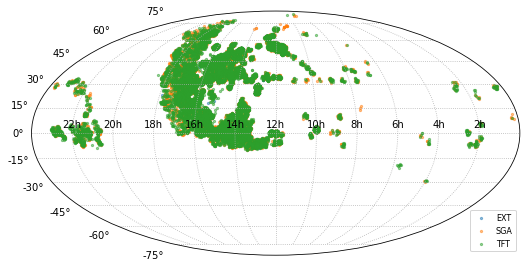

In [8]:
fig = plot_radec(tf_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [9]:
isgoodz = (tf_targets['deltachi2']>= 25) & (tf_targets['zwarn']==0)
np.sum(isgoodz)

19480

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


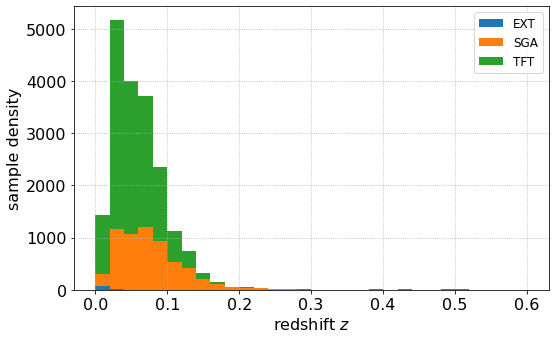

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_targets['pvtype'])
for pvtype in pvtypes:
    ispvtype = tf_targets['pvtype'] == pvtype
    zdata.append(list(tf_targets[isgoodz & ispvtype]['z']))

zbins = np.linspace(0,0.6,31)
ax.hist(zdata, bins=zbins, stacked=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='sample density')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Read in list of PV Targets
PV targets from above desi query

In [11]:
PV_filename = 'tf_targets.fits'

hdu = fits.open(PV_filename)
PV_observed = QTable(hdu[1].data)
hdu.close()

len(PV_observed)

25497

In [12]:
PV_observed[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,GALAXY,33952.1068879628,0,69412,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,GALAXY,53137.0094233155,0,69412,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,GALAXY,33245.3577982187,0,69412,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,GALAXY,11625.5793859102,0,69213,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,GALAXY,57099.7675513407,0,69412,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,GALAXY,12976.2707899213,0,69412,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,GALAXY,4275.01541189849,0,69412,20201222
TFT,269195,39628462834585206,35.9738797902803,29.3592905954632,-0.00199570145091582,STAR,1.94266889222573e+84,1570,69412,20201222


## Identify SGA Galaxies

In [13]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

SGA[:10]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

## Match DESI targets to SGA catalog

In [14]:
SGA_coords = SkyCoord(ra=SGA['RA']*u.degree, dec=SGA['DEC']*u.degree)
PV_coords = SkyCoord(ra=PV_observed['target_ra']*u.degree, dec=PV_observed['target_dec']*u.degree)

idx, sep2d, dist3d = match_coordinates_sky(PV_coords, SGA_coords, nthneighbor=1)

PV_observed['IDX_SGA'] = idx
PV_observed['SKY_TARGET_DIST_SGA'] = sep2d

### Stack the PV and SGA Tables

Make an `hstack` of the `PV_observed` and `SGA` tables using rows that matched PV coordinates to SGA centers. This will put all the relevant information into a single table that we'll call `PV_matched`.

In [15]:
PV_matched = hstack([PV_observed, SGA[idx]])

# Print the table to demonstrate that we've matched across the rows between PV_observed and SGA.
PV_matched[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.009043296,0.009962468,0.



#### Matching SGA IDs?

Making the `hstack` of the `PV_observed` and `SGA` tables changes some of the columns in the merged table. After the stack:
- `SGA_ID` in `PV_observed` becomes `SGA_ID_1`. This corresponds to the SGA ID returned by the database query of TF targets at NERSC.
- `SGA_ID` in `SGA` becomes `SGA_ID_2` in the merged table. This is the SGA ID of the galaxy that is the nearest neighbor of the DESI target in each row of the merged table.

Note that many if not most of the `SGA_ID_1` values will be zero b/c that's what is returned by the current query (as of end of June 2021). Here we check that when `SGA_ID_1` is nonzero, then it matches `SGA_ID_2`. For cases that don't match, it may be due to the fact that the correct SGA ID is *not* the nearest neighbor of that particular DESI target. 

In [16]:
# Grab a boolean array where the sga_id is nonzero.
is_nonzero_id = PV_matched['sga_id'] != 0

# For all rows where sga_id is nonzero, print sga_id and SGA_ID.
PV_matched[is_nonzero_id]['sga_id', 'SGA_ID']

sga_id,SGA_ID
int64,int64
227887,227887
249627,249627
581116,581116
879849,879849
1215253,1215253
1329026,1329026
161400,161400
173880,173880
269195,269195


## Histogram of matched DESI and SGA data

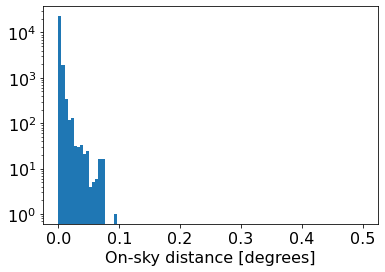

In [19]:
plt.figure()

plt.hist(PV_matched['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0, 0.5, 100))
#plt.hist(PV_SGA_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0,1,100))

plt.yscale('log')

plt.xlabel('On-sky distance [degrees]');

## Define a function to evaluate arbitrary SGA ellipses

This provides a check to make sure that the TF targets actually fall within the SGA galaxy that `match_coordinates_sky` assigns them to. The results of the check show that `match_coordinates_sky` correctly matched all 25,497 TF targets with their galaxy using `nthneighbor=1`.

In [20]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']

center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [60]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

print('The SGA crossmatch correctly matches', len(galaxy_targets), 'out of the', len(PV_matched), 'DESI targets.') 

The SGA crossmatch correctly matches 25497 out of the 25497 DESI targets.


In [22]:
galaxy_targets[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.009043296,0.009962468,0.

## Grace's attempt to calculate rotation velocities

For a given SGA galaxy, we can match that center with all other rows in the targets data file that have the same SGA ID. These include the TFT and EXT targets. The goal is to find SGA observations with at least one TFT or EXT target.

The distance and velocity must be calculated for the repeated SGA IDs to later use in plotting on the MaNGA rotation curves.

In [43]:
def rot_vel(targets):
    ''''
    Calculates the rotation velocity for each observation in a table given redshift measurments for the target and the
    corresponding galactic center.
   
    Parameters- 
        targets: astropy table containing the DESI observations for an SGA galaxy. Must include redshift -z- and the 
        distance between the DESI and SGA object -SKY_TARGET_DIST_SGA.

    '''
    center_idx = np.argmin(targets['SKY_TARGET_DIST_SGA'])
    targets['rot_vel'] = const.c.to('km/s')*(targets['z'] - targets[center_idx]['z'])
    #print("NoTargets, ", len(targets), ". CenterIndex, ", center_idx, ". CenterValue, ",targets[center_idx]['z'])
    return targets

In [42]:
PV_SGA_table = None

for i in np.unique(PV_matched['IDX_SGA']):
    idx_bool = PV_matched['IDX_SGA'] == i
    matched_targets = PV_matched[idx_bool]
    if len(matched_targets)>1 and len(np.unique(matched_targets['targetid'])>1):
        matched_targets = rot_vel(matched_targets)
        
        if PV_SGA_table == None:
            PV_SGA_table = matched_targets
        else:
            PV_SGA_table = vstack([PV_SGA_table, matched_targets])

In [40]:
print(len(PV_SGA_table))
PV_SGA_table[:10]

10464


pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64
TFT,123,39633304835591852,242.564968458214,53.671192794853,0.109961593202666,GALAXY,798.715203851461,0,84241,20210410,37,2.5449483280548343e-14,123,SGA-2020 123,SDSSJ161015.59+534016.9,4013284,242.564988,53.6713965,,177.55,0.4864072,0.24099056,0.11020523,25.572481,18.509,False,LEDA-20181114,37,SDSSJ161015.59+534016.9,1,True,242.564988,53.6713965,0.4864072,2424p537,242.56496845821403,53.67119279485298,0.616147,SB26,179.40706,0.28592724,242.56481637357078,53.67121754262578,10.889907,10.891897,7.98995,7.8607693,2.6842482,5.5872498,8.5082035,10.917659,12.731412,14.379442,15.662769,17.056347,18.48441,20.53574,19.58069,19.025324,19.267328,18.379307,17.829762,18.642546,17.802114,17.280466,18.321804,17.510208,17.000744,18.150011,17.352724,16.850945,18.026978,17.267302,16.766031,17.9467,17.23381,16.730644,17.882294,17.206663,16.708782,17.861124,17.192705,16.69682,0.09179839,0.13749011,0.18808271,0.21521349,0.18915926,0.13408832,0.17005289,0.18807316,0.1771464,0.06015116,0.09011364,0.09714287,0.048842907,0.06227592,0.066935055,0.042053133,0.050186858,0.053028066,0.037597448,0.0440989,0.046041466,0.035193264,0.040932804,0.042617496,0.0333

In [47]:
#Calculate the distance from the galactic center and the velocity for the repeated SGA galaxies
H0 = 70*u.km/u.s/u.Mpc
const.c.to('km/s')
z = PV_SGA_table['z']
dist = ((const.c*z).to('km/s')/H0).to('kpc')

sep_rad = PV_SGA_table['SKY_TARGET_DIST_SGA'].to('radian')
sep_kpc = dist * np.tan(sep_rad)

In [48]:
#adds a column for the distance to the galactic centers 
table_2 = hstack([PV_SGA_table, sep_kpc])
table_2.rename_column('col0', 'Distance from galactic center')
table_2[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel,Distance from galactic center
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,kpc
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
TFT,123,39633304835591852,242.564968458214,53.671192794853,0.109961593202666,GALAXY,798.715203851461,0,84241,20210410,37,2.5449483280548343e-14,123,SGA-2020 123,SDSSJ161015.59+534016.9,4013284,242.564988,53.6713965,,177.55,0.4864072,0.24099056,0.11020523,25.572481,18.509,False,LEDA-20181114,37,SDSSJ161015.59+534016.9,1,True,242.564988,53.6713965,0.4864072,2424p537,242.56496845821403,53.67119279485298,0.616147,SB26,179.40706,0.28592724,242.56481637357078,53.67121754262578,10.889907,10.891897,7.98995,7.8607693,2.6842482,5.5872498,8.5082035,10.917659,12.731412,14.379442,15.662769,17.056347,18.48441,20.53574,19.58069,19.025324,19.267328,18.379307,17.829762,18.642546,17.802114,17.280466,18.321804,17.510208,17.000744,18.150011,17.352724,16.850945,18.026978,17.267302,16.766031,17.9467,17.23381,16.730644,17.882294,17.206663,16.708782,17.861124,17.192705,16.69682,0.09179839,0.13749011,0.18808271,0.21521349,0.18915926,0.13408832,0.17005289,0.18807316,0.1771464,0.06015116,0.09011364,0.09714287,0.048842907,0.06227592,0.066935055,0.042053133,0.050186858,0.053028066,0.037597448,0.0440989,0.046041466,

In [49]:
#This step eliminates unrealistic rotatation velocities. 
good_velocities = table_2['rot_vel'] < 1000*u.km/u.second 
almost_final_data = table_2[good_velocities]
better_velocities = almost_final_data['rot_vel'] > 1*u.km/u.second
final_data = almost_final_data[better_velocities]

print(len(final_data))
final_data[:10]

1509


pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,rot_vel,Distance from galactic center
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,kpc
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
TFT,1548,1070869912748034,252.860062744453,33.03565124542,0.0625663809387951,GALAXY,414.929026573896,0,90248,20210529,440,0.0014817091303627686,1548,SGA-2020 1548,SDSSJ165126.59+330203.5,3502220,252.86077650000004,33.0343507,S?,154.1,0.4508167,0.4466836,0.062078945,25.027481,18.129,False,LEDA-20181114,440,SDSSJ165126.59+330203.5,1,True,252.86077650000004,33.0343507,0.4508167,2527p330,252.86079970098154,33.03430448556036,0.53880334,SB26,155.35718,0.47351485,252.86066909405264,33.034360686080134,12.597376,6.584361,5.8151336,4.142423,3.323081,4.8804545,6.415447,7.9999123,9.597124,11.154015,12.78003,14.538747,16.1641,19.366194,18.418495,17.676432,18.797308,17.914637,17.265965,18.457354,17.619967,17.034483,18.227644,17.417562,16.88301,18.076956,17.286598,16.793627,17.982859,17.20239,16.745651,17.912136,17.143084,16.721899,17.857784,17.100485,16.709152,17.817442,17.070053,16.707008,0.018727673,0.036042005,0.038202766,0.05129338,0.047407247,0.068421446,0.08510804,0.12238743,0.09439984,0.014373892,0.020639302,0.030724164,0.012427286,0.015752278,0.02315442,0.011548264,0.013715157,0.019837318,0.0

## MaNGA and SGA Crossmatch

Download the MaNGA data from the following URL and import it as a .txt file: http://www.pas.rochester.edu/~kdouglass/Research/data/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt

See the following Jupyter notebook for the crossmatch of the MaNGA data with the SGA-2020 catalog:
https://github.com/gracechiodo/tf_spiral_galaxy/blob/main/MaNGA_SGA_crossmatch.ipynb

In [50]:
SGA_MaNGA = Table.read('MaNGA_SGA_data.txt', format='ascii.commented_header')
print(len(SGA_MaNGA))
SGA_MaNGA[:10]

3841


MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,imc,aimc,cd,IDX_SGA,DISTANCE_MANGA_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,int64,str16,str23,int64,float64,float64,str4,float64,float64,float64,float64,float64,float64,str5,str13,int64,str29,int64,str5,float64,float64,float64,str8,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

## Plot the rotation curves for the MaNGA data with SGA matches

Each plot will include the rotation curve generatede from the MaNGA data as well as the corresponding points from the DESI data. We can inner join the two data sets on the 'SGA_ID' values.

In [51]:
DESI_MaNGA_final = join(final_data, SGA_MaNGA, keys='SGA_ID')
print(len(DESI_MaNGA_final))
DESI_MaNGA_final[:10]

68


pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA_1,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY_1,GALAXY_1,PGC_1,RA_LEDA_1,DEC_LEDA_1,MORPHTYPE_1,PA_LEDA_1,D25_LEDA_1,BA_LEDA_1,Z_LEDA_1,SB_D25_LEDA_1,MAG_LEDA_1,BYHAND_1,REF_1,GROUP_ID_1,GROUP_NAME_1,GROUP_MULT_1,GROUP_PRIMARY_1,GROUP_RA_1,GROUP_DEC_1,GROUP_DIAMETER_1,BRICKNAME_1,RA_1,DEC_1,D26_1,D26_REF_1,PA_1,BA_1,RA_MOMENT_1,DEC_MOMENT_1,SMA_MOMENT_1,G_SMA50_1,R_SMA50_1,Z_SMA50_1,SMA_SB22_1,SMA_SB22.5_1,SMA_SB23_1,SMA_SB23.5_1,SMA_SB24_1,SMA_SB24.5_1,SMA_SB25_1,SMA_SB25.5_1,SMA_SB26_1,G_MAG_SB22_1,R_MAG_SB22_1,Z_MAG_SB22_1,G_MAG_SB22.5_1,R_MAG_SB22.5_1,Z_MAG_SB22.5_1,G_MAG_SB23_1,R_MAG_SB23_1,Z_MAG_SB23_1,G_MAG_SB23.5_1,R_MAG_SB23.5_1,Z_MAG_SB23.5_1,G_MAG_SB24_1,R_MAG_SB24_1,Z_MAG_SB24_1,G_MAG_SB24.5_1,R_MAG_SB24.5_1,Z_MAG_SB24.5_1,G_MAG_SB25_1,R_MAG_SB25_1,Z_MAG_SB25_1,G_MAG_SB25.5_1,R_MAG_SB25.5_1,Z_MAG_SB25.5_1,G_MAG_SB26_1,R_MAG_SB26_1,Z_MAG_SB26_1,SMA_SB22_ERR_1,SMA_SB22.5_ERR_1,SMA_SB23_ERR_1,SMA_SB23.5_ERR_1,SMA_SB24_ERR_1,SMA_SB24.5_ERR_1,SMA_SB25_ERR_1,SMA_SB25.5_ERR_1,SMA_SB26_ERR_1,G_MAG_SB22_ERR_1,R_MAG_SB22_ERR_1,Z_MAG_SB22_ERR_1,G_MAG_SB22.5_ERR_1,R_MAG_SB22.5_ERR_1,Z_MAG_SB22.5_ERR_1,G_MAG_SB23_ERR_1,R_MAG_SB23_ERR_1,Z_MAG_SB23_ERR_1,G_MAG_SB23.5_ERR_1,R_MAG_SB23.5_ERR_1,Z_MAG_SB23.5_ERR_1,G_MAG_SB24_ERR_1,R_MAG_SB24_ERR_1,Z_MAG_SB24_ERR_1,G_MAG_SB24.5_ERR_1,R_MAG_SB24.5_ERR_1,Z_MAG_SB24.5_ERR_1,G_MAG_SB25_ERR_1,R_MAG_SB25_ERR_1,Z_MAG_SB25_ERR_1,G_MAG_SB25.5_ERR_1,R_MAG_SB25.5_ERR_1,Z_MAG_SB25.5_ERR_1,G_MAG_SB26_ERR_1,R_MAG_SB26_ERR_1,Z_MAG_SB26_ERR_1,G_COG_PARAMS_MTOT_1,G_COG_PARAMS_M0_1,G_COG_PARAMS_ALPHA1_1,G_COG_PARAMS_ALPHA2_1,G_COG_PARAMS_CHI2_1,R_COG_PARAMS_MTOT_1,R_COG_PARAMS_M0_1,R_COG_PARAMS_ALPHA1_1,R_COG_PARAMS_ALPHA2_1,R_COG_PARAMS_CHI2_1,Z_COG_PARAMS_MTOT_1,Z_COG_PARAMS_M0_1,Z_COG_PARAMS_ALPHA1_1,Z_COG_PARAMS_ALPHA2_1,Z_COG_PARAMS_CHI2_1,ELLIPSEBIT_1,rot_vel,Distance from galactic center,MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,vflag,avg_v_max,avg_v_max_sigma,avg_alpha,avg_alpha_sigma,avg_chi_square_rot,pos_v_max,pos_v_max_sigma,pos_alpha,pos_alpha_sigma,pos_chi_square_rot,neg_v_max,neg_v_max_sigma,neg_alpha,neg_alpha_sigma,neg_chi_square_rot,center_flux,center_flux_error,Mtot,Mtot_error,Mdark,Mdark_error,Mstar,Mdark_Mstar_ratio,Mdark_Mstar_ratio_error,rabsmag,avg_r_turn,avg_r_turn_sigma,pos_r_turn,pos_r_turn_sigma,neg_r_turn,neg_r_turn_sigma,logNO,t3,BPT,curve_used,points_cut,avg_chi_square_ndf,pos_chi_square_ndf,neg_chi_square_ndf,index,Z12logOH,u_r,frac_masked_spaxels,Rmax,Mtot_Mstar_ratio,Mtot_Mstar_ratio_error,smoothness_score,pos_Vmax_data,avg_Vmax_data,neg_Vmax_data,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,Sigma_disk_map,Sigma_disk_err_map,Rdisk_map,Rdisk_err_map,M90_disk_map,M90_disk_err_map,DRP_map_smoothness,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,WF50,WP20,CMD_class,map_fit_flag,imc,aimc,cd,IDX_SGA_2,DISTANCE_MANGA_SGA,SGA_GALAXY_2,GALAXY_2,PGC_2,RA_LEDA_2,DEC_LEDA_2,MORPHTYPE_2,PA_LEDA_2,D25_LEDA_2,BA_LEDA_2,Z_LEDA_2,SB_D25_LEDA_2,MAG_LEDA_2,BYHAND_2,REF_2,GROUP_ID_2,GROUP_NAME_2,GROUP_MULT_2,GROUP_PRIMARY_2,GROUP_RA_2,GROUP_DEC_2,GROUP_DIAMETER_2,BRICKNAME_2,RA_2,DEC_2,D26_2,D26_REF_2,PA_2,BA_2,RA_MOMENT_2,DEC_MOMENT_2,SMA_MOMENT_2,G_SMA50_2,R_SMA50_2,Z_SMA50_2,SMA_SB22_2,SMA_SB22.5_2,SMA_SB23_2,SMA_SB23.5_2,SMA_SB24_2,SMA_SB24.5_2,SMA_SB25_2,SMA_SB25.5_2,SMA_SB26_2,G_MAG_SB22_2,R_MAG_SB22_2,Z_MAG_SB22_2,G_MAG_SB22.5_2,R_MAG_SB22.5_2,Z_MAG_SB22.5_2,G_MAG_SB23_2,R_MAG_SB23_2,Z_MAG_SB23_2,G_MAG_SB23.5_2,R_MAG_SB23.5_2,Z_MAG_SB23.5_2,G_MAG_SB24_2,R_MAG_SB24_2,Z_MAG_SB24_2,G_MAG_SB24.5_2,R_MAG_SB24.5_2,Z_MAG_SB24.5_2,G_MAG_SB25_2,R_MAG_SB25_2,Z_MAG_SB25_2,G_MAG_SB25.5_2,R_MAG_SB25.5_2,Z_MAG_SB25.5_2,G_MAG_SB26_2,R_MAG_SB26_2,Z_MAG_SB26_2,SMA_SB22_ERR_2,SMA_SB22.5_ERR_2,SMA_SB23_E

Some of the targets were eliminated due to high rotation velocities, and others did not have a match in MaNGA. The data table should be further cut to include only the galaxies that still have 2 or more DESI observations

In [52]:
u_2, c_2 = np.unique(DESI_MaNGA_final['sga_id'], return_counts=True)
multiple_sga = c_2 > 1

sum_2 = 0
for i in c_2:
    if i > 1:
        sum_2 = sum_2+i
print(sum_2)

multiple_sga = u_2[multiple_sga]
len(multiple_sga)

45


19

Plot the rotation curve for the galaxies with multiple DESI observations. 

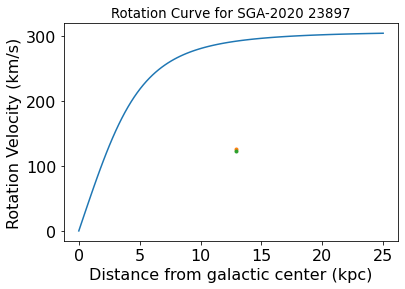

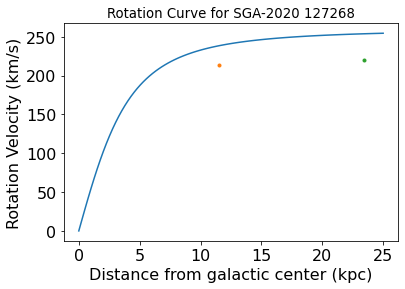

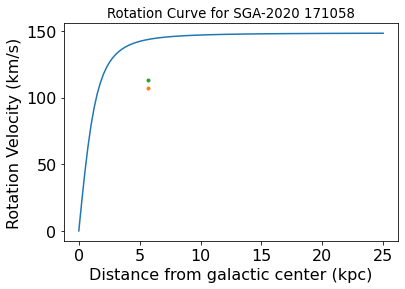

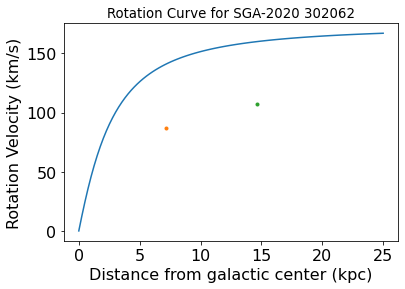

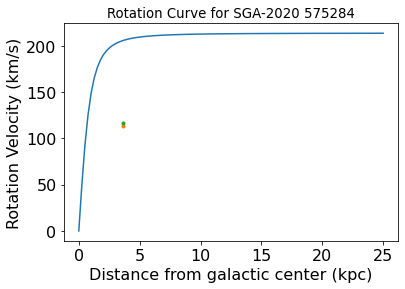

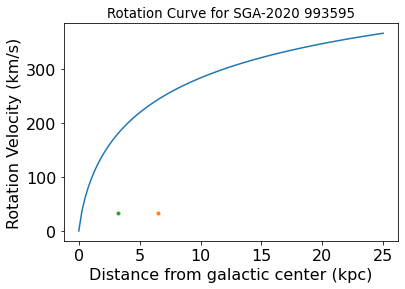

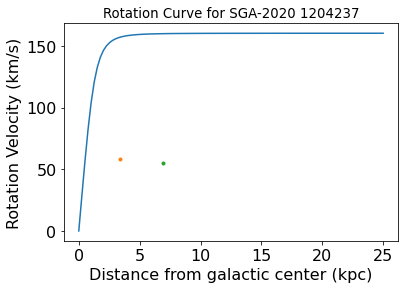

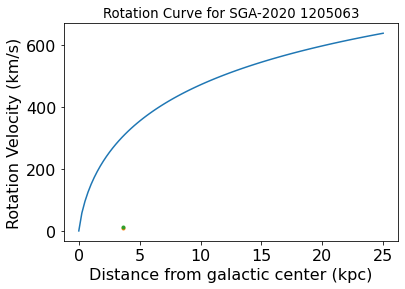

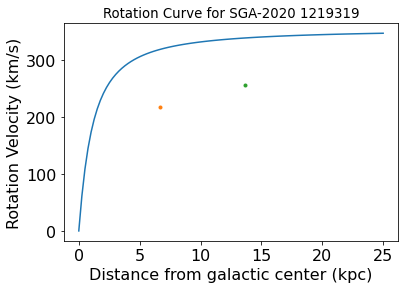

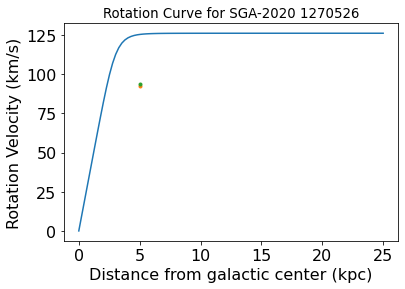

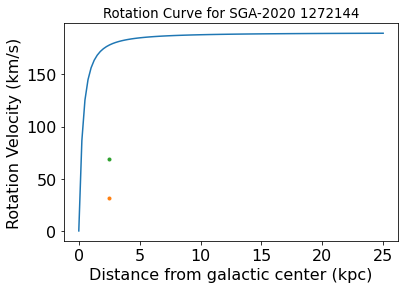

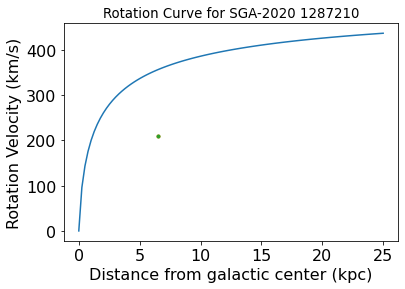

In [53]:
r = np.linspace(0, 25, 100)

for i in multiple_sga:
    findIdx = DESI_MaNGA_final['sga_id'] == i
    data_idx = DESI_MaNGA_final[findIdx]
    v_max = data_idx['Vmax_map'][0]
    
    if v_max != -99:
    
        Velocity_num = data_idx['Vmax_map'][0]*r 
        Velocity_den = ((data_idx['Rturn_map'][0]**data_idx['alpha_map'][0]) 
                          + (r**data_idx['alpha_map'][0]))**(1/data_idx['alpha_map'][0])
        Velocity_curve = Velocity_num/Velocity_den
        desi_vel_0 = data_idx['rot_vel'][0]
        desi_dist_0 = data_idx['Distance from galactic center'][0]
        desi_vel_1 = data_idx['rot_vel'][1]
        desi_dist_1 = data_idx['Distance from galactic center'][1]
        galaxy_name = 'Rotation Curve for {gname}'.format(gname = str(data_idx['SGA_GALAXY_1'][0]))

        plt.figure()
        
        plt.plot(r, Velocity_curve)
        plt.plot(desi_dist_0, desi_vel_0,'.')
        plt.plot(desi_dist_1, desi_vel_1,'.')
        plt.xlabel('Distance from galactic center (kpc)')
        plt.ylabel('Rotation Velocity (km/s)')
        plt.title(galaxy_name)